<h2><b>Data Analytics Assignment 3</b></h2>

<h3><b>By: Alex Litchfield</b></h3>

<h3><b>Q2. Data Description and preliminary analysis</b></h3>

In [249]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#https://data.cdc.gov/National-Center-for-Health-Statistics/Mental-Health-Care-in-the-Last-4-Weeks/yni7-er2q/about_data
#https://data.cdc.gov/National-Center-for-Health-Statistics/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab/about_data
mentalHealthData = pd.read_csv("Mental_Health_Care_in_the_Last_4_Weeks_20251209.csv")
covidData = pd.read_csv("Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State_20251209.csv")

In [ ]:
# Each row with the (Group, Subgroup) combo that is NOT ('By State', state name) has its state listed as United States'
# These categories are not included because they are generally just noise (repeat info)
combo_counts = (
    mentalHealthData
        .groupby(['Group', 'Subgroup', 'State'])
        .size()
        .reset_index(name='count')
        .sort_values(['Group', 'Subgroup'])
)

print(combo_counts.to_string())

                                            Group                                                               Subgroup                 State  count
0                                          By Age                                                          18 - 29 years         United States    152
1                                          By Age                                                          30 - 39 years         United States    152
2                                          By Age                                                          40 - 49 years         United States    152
3                                          By Age                                                          50 - 59 years         United States    152
4                                          By Age                                                          60 - 69 years         United States    152
5                                          By Age                                                   

<h3><b>Q3. Exploratory Analysis</b></h3>

<h4><b>Data Cleaning</b></h4>

In [251]:
# Removing unecessary columns from original datasets
# Removing rows with NA values in required columns
# Converting dates to datetime objects to ensure compatability
mentalHealthData = mentalHealthData[['Indicator', 'State', 'Time Period Start Date', 'Time Period End Date']]
mentalHealthData = mentalHealthData.dropna()
mentalHealthData['Time Period Start Date'] = pd.to_datetime(covidData['Start Date'])
mentalHealthData['Time Period End Date'] = pd.to_datetime(covidData['End Date'])

covidData = covidData[['Start Date', 'End Date', 'State', 'COVID-19 Deaths', 'Total Deaths']]
covidData = covidData.dropna()
covidData['Start Date'] = pd.to_datetime(covidData['Start Date'])
covidData['End Date'] = pd.to_datetime(covidData['End Date'])

<h4><b>Data Organization</b></h4>

In [252]:
# Create new dataset for covidData which includes day to day statistics
# Since current covid data is based on a range, all dates within that range
# will be provided the mean number of deaths from the range

dailyCovidData = []

for _, row in covidData.iterrows():
    # Store row information and convert to numbers if need be
    startDate = row['Start Date']
    endDate = row['End Date']
    state = row['State']
    covidDeaths = int(row['COVID-19 Deaths'].replace(',', ''))
    totalDeaths = int(row['Total Deaths'].replace(',', ''))
    
    # Generates an inclusive list of calendar days in the range
    dateRange = pd.date_range(startDate, endDate, freq = 'D')
    numDaysInRange = len(dateRange)
    
    # Deaths per day (split evenly) and rounded to 2 decimal places
    dailyCovidDeaths = covidDeaths / numDaysInRange if numDaysInRange > 0 else 0
    dailyTotalDeaths = totalDeaths / numDaysInRange if numDaysInRange > 0 else 0
    
    # Create expanded rows
    for d in dateRange:
        dailyCovidData.append({
            'State': state,
            'Date': d,
            'COVID-19 Deaths': dailyCovidDeaths,
            'Total Deaths': dailyTotalDeaths
        })

# Print size of dailyCovidData
dailyCovidData = pd.DataFrame(dailyCovidData)
print("Total rows in dailyCovidData before duplicate removal:", len(dailyCovidData))

# Aggregate dailyCovidData by State and Date
# Take mean of COVID-19 Deaths and Total Deaths if there are multiple of the same state/date combination
dailyCovidData = (
    dailyCovidData
    .groupby(['State', 'Date'], as_index = False)
    .agg({
        'COVID-19 Deaths': 'mean',
        'Total Deaths': 'mean'
    })
)

# Sorting by State and Date and taking the cumulative sum of each state and date column
dailyCovidData = dailyCovidData.sort_values(['State', 'Date'])
dailyCovidData['Cumulative COVID-19 Deaths'] = dailyCovidData.groupby('State')['COVID-19 Deaths'].cumsum()
dailyCovidData['Cumulative Total Deaths'] = dailyCovidData.groupby('State')['Total Deaths'].cumsum()

# Print new reduced size
print("Total rows in dailyCovidData after duplicate removal:", len(dailyCovidData))

Total rows in dailyCovidData before duplicate removal: 411659
Total rows in dailyCovidData after duplicate removal: 113022


In [ ]:
# Creating finalData table by taking all rows from mentalHealthdata and
# for each appending the covid and total death numbers from the dailyCovidData rows
# which fall into that daterange and are in the same state

# Cumulative totals will be that of the latest date

# Expected runtime for this block: 8.5 minutes

finalData = []

for _, row in mentalHealthData.iterrows():
    
    # Store existing row information
    indicator = row['Indicator']
    state = row['State']
    startDate = row['Time Period Start Date']
    endDate = row['Time Period End Date']
    
    # Generates an inclusive list of calendar days in the range
    dateRange = pd.date_range(startDate, endDate, freq = 'D')
    numDaysInRange = len(dateRange)

    # Find corresponding information related to deaths from dailyCovidData
    covidDeathsInRange = 0
    TotalDeathsInRange = 0
    CumulativeCovidDeaths = 0
    CumulativeTotalDeaths = 0
    for currentDate in dateRange:
        filteredRow = dailyCovidData[(
            (dailyCovidData['State'] == state) &
            (dailyCovidData['Date'] == currentDate)
        )]
        covidDeathsInRange = covidDeathsInRange + filteredRow['COVID-19 Deaths'].values[0]
        TotalDeathsInRange = TotalDeathsInRange + filteredRow['Total Deaths'].values[0]
        CumulativeCovidDeaths = filteredRow['Cumulative COVID-19 Deaths'].values[0]
        CumulativeTotalDeaths = filteredRow['Cumulative Total Deaths'].values[0]
    
    # Create expanded rows
    finalData.append({
        'State': state,
        'Start Date': startDate,
        'End Date': endDate,
        'Indicator': indicator,
        'COVID-19 Deaths': covidDeathsInRange,
        'Total Deaths': TotalDeathsInRange,
        'Cumulative COVID-19 Deaths': CumulativeCovidDeaths,
        'Cumulative Total Deaths': CumulativeTotalDeaths
    })
    
finalData = pd.DataFrame(finalData)

# Rounding decimal values to 2 decimal places
finalData['Cumulative COVID-19 Deaths'] = finalData['Cumulative COVID-19 Deaths'].round(2)
finalData['Cumulative Total Deaths'] = finalData['Cumulative Total Deaths'].round(2)
finalData['COVID-19 Deaths'] = finalData['COVID-19 Deaths'].round(2)
finalData['Total Deaths'] = finalData['Total Deaths'].round(2)

# Print size of finalData and mentalHealthData (should be equal)
print("Total rows in finalData:", len(finalData))
print("Total rows mentalHealthData:", len(mentalHealthData))


Total rows in finalData: 10404
Total rows mentalHealthData: 10404


In [254]:
# Displaying the distribution of rows between states and that it is equal
finalData['State'].value_counts()

State
United States           3672
Alabama                  132
Alaska                   132
Arizona                  132
Arkansas                 132
California               132
Colorado                 132
Connecticut              132
Delaware                 132
District of Columbia     132
Florida                  132
Georgia                  132
Hawaii                   132
Idaho                    132
Illinois                 132
Indiana                  132
Iowa                     132
Kansas                   132
Kentucky                 132
Louisiana                132
Maine                    132
Maryland                 132
Massachusetts            132
Michigan                 132
Minnesota                132
Mississippi              132
Missouri                 132
Montana                  132
Nebraska                 132
Nevada                   132
New Hampshire            132
New Jersey               132
New Mexico               132
New York                 132
North Ca

<h4><b>Histograms for Numeric Data</b></h4>

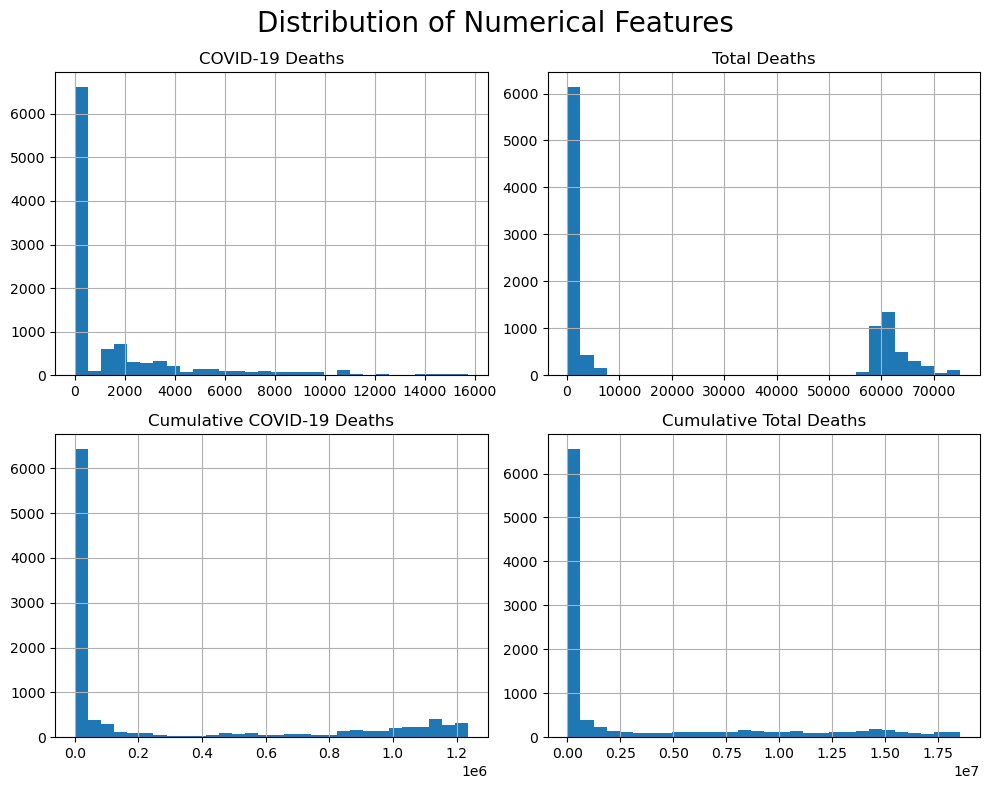

In [255]:
# Displays histograms of all numerical features in the dataset
numeric_df = finalData.select_dtypes(include=[np.number])
numeric_df.hist(bins=  30, figsize = (10, 8))
plt.suptitle("Distribution of Numerical Features", fontsize = 20)
plt.tight_layout()
plt.show()

<h4><b>Boxplots for Numeric Data and Covid19 Deaths vs Mental Health Indicators</b></h4>

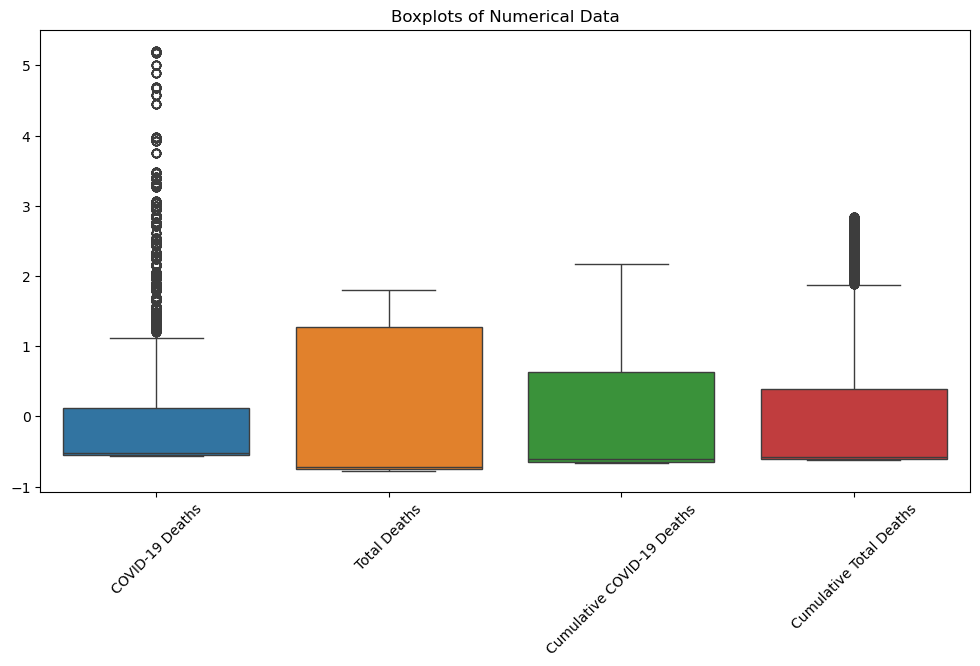

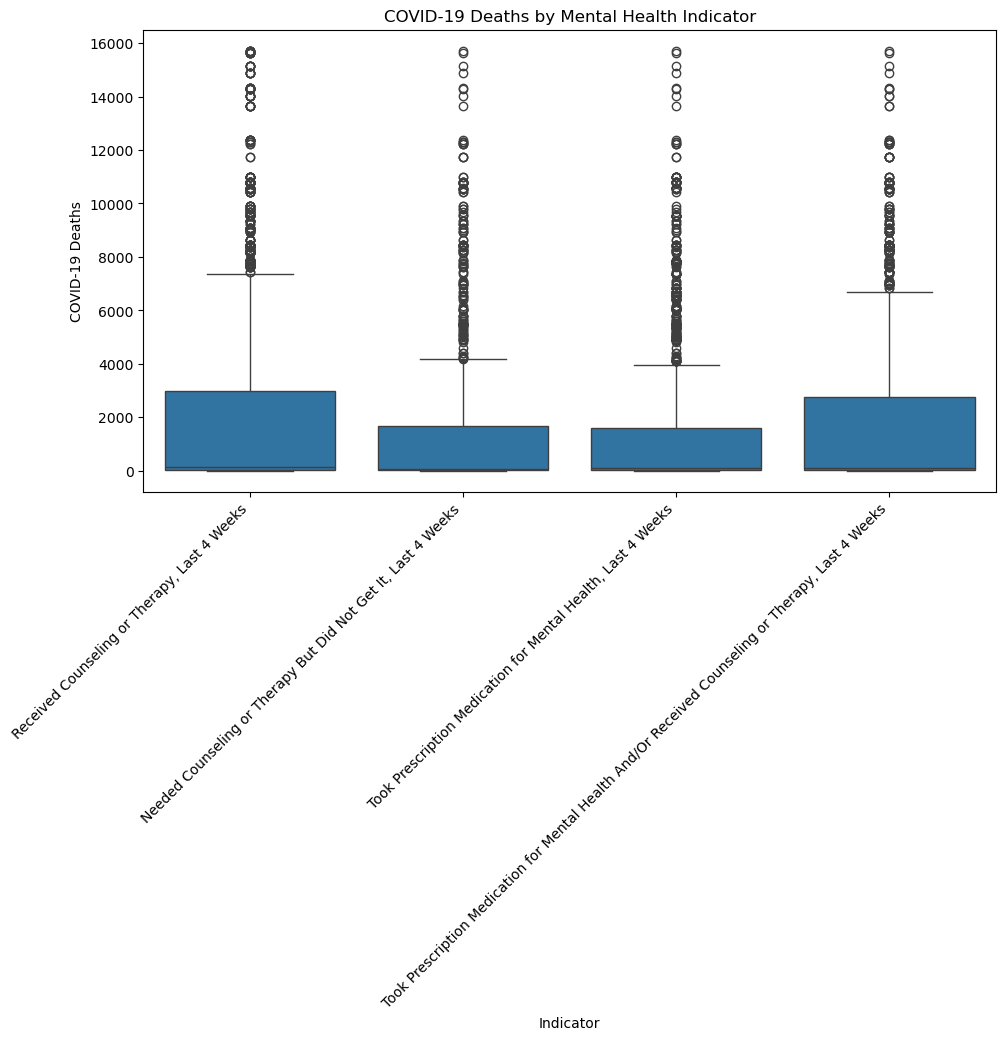

In [256]:
# Scale numeric data so it shows better on boxplot
scaler = StandardScaler()
numeric_df_scaled = pd.DataFrame(scaler.fit_transform(numeric_df), columns = numeric_df.columns)

# Print boxplots of numeric data
plt.figure(figsize = (12, 6))
sns.boxplot(data = numeric_df_scaled)
plt.xticks(rotation = 45)
plt.title("Boxplots of Numerical Data")
plt.show()

# Print boxplots of Covid-19 deaths by mental health indicator
plt.figure(figsize=(11, 6))
sns.boxplot(data=finalData, x = "Indicator", y = "COVID-19 Deaths")
plt.xticks(rotation = 45, ha = "right")
plt.title("COVID-19 Deaths by Mental Health Indicator")
plt.show()

<h4><b>Scatterplots displaying Covid-19 Deaths, Total Deaths, Cumulative Covid-19 Deaths, and Cumulative Total Deaths by State</b></h4>

In [ ]:
# Displays the given statistic state by state
def showScatterplot(statisticColumn):
    # United States was removed to show the contrast between individual states
    # Plot displays ALL states
    plt.figure(figsize=(14, 6))
    sns.lineplot(data = finalData[finalData["State"] != "United States"],
                 x = "Start Date", y = statisticColumn, hue = "State")
    plt.title(statisticColumn + " Over Time by State")
    plt.xlabel("Date")
    plt.ylabel(statisticColumn + " per Period")
    # Legend is on the outside of the plot to prevent blocking it
    plt.legend(title = "State", loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncol = 7)

    ##########

    # Metric per state (sum over all periods)
    stateTotals = finalData[finalData["State"] != "United States"].groupby("State")[statisticColumn].sum().sort_values()
    # Computing quartiles
    quartile25State = (stateTotals.quantile(0.25) - stateTotals).abs().idxmin()
    quartile50State = (stateTotals.quantile(0.50) - stateTotals).abs().idxmin()
    quartile75State = (stateTotals.quantile(0.75) - stateTotals).abs().idxmin()
    quartileMaxState = (stateTotals.max() - stateTotals).abs().idxmin()
    # Converted to a list for easier plotting
    selected_states = list({quartile25State, quartile50State, quartile75State, quartileMaxState, "New Hampshire"})
    # Plot displays 4 States in the 25%, 50%, 75%, and max quartiles of metric plus NH (my home state)
    plt.figure(figsize=(12,6))
    sns.lineplot(data = finalData[finalData["State"].isin(selected_states)],
                 x = "Start Date", y = statisticColumn, hue = "State")
    plt.title(statisticColumn + " Over Time (Quantile Representative States and New Hampshire)")
    plt.xlabel("Date")
    plt.ylabel(statisticColumn + " per Period")
    plt.legend(title = "State")
    plt.tight_layout()
    plt.show()


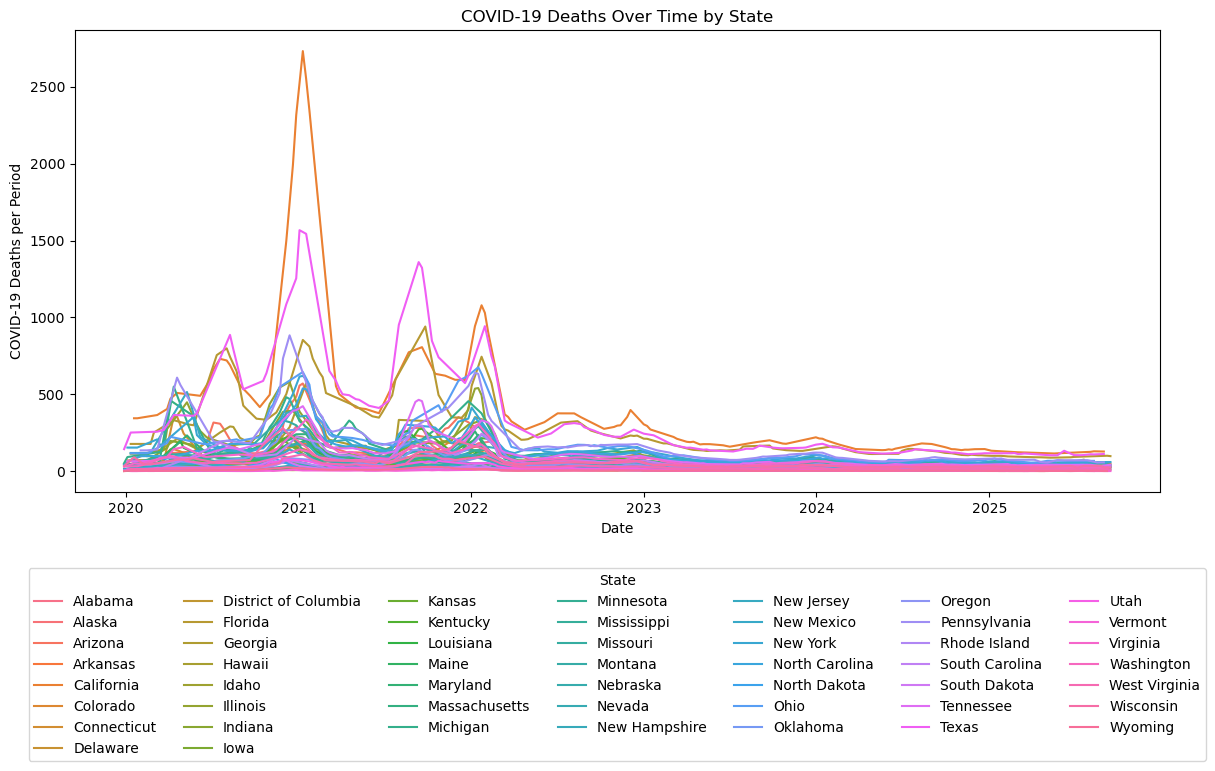

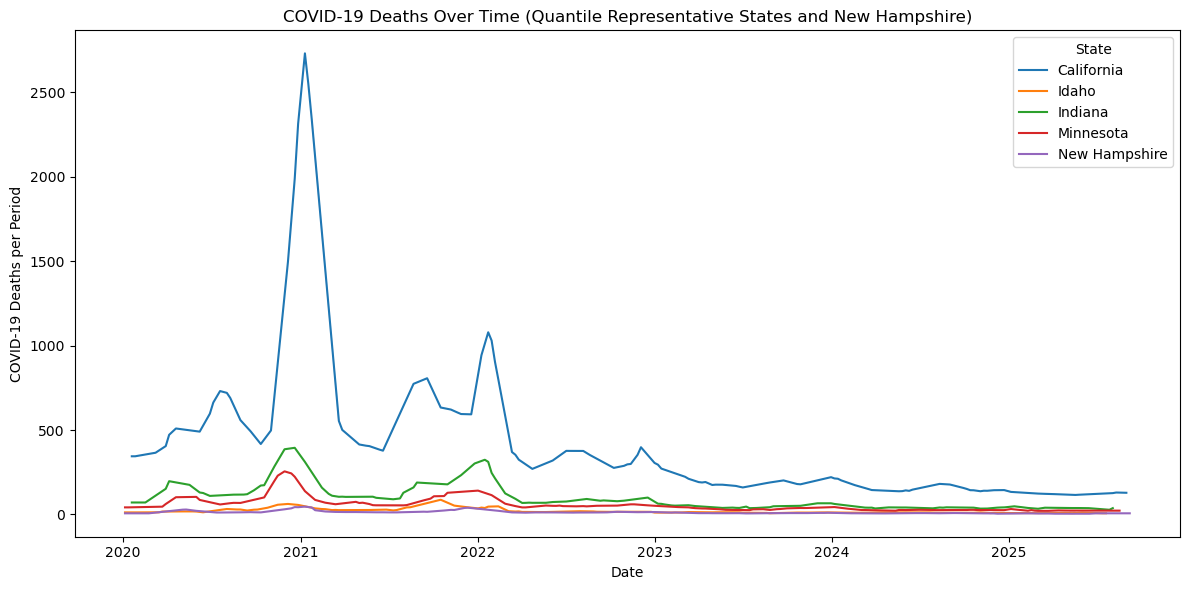

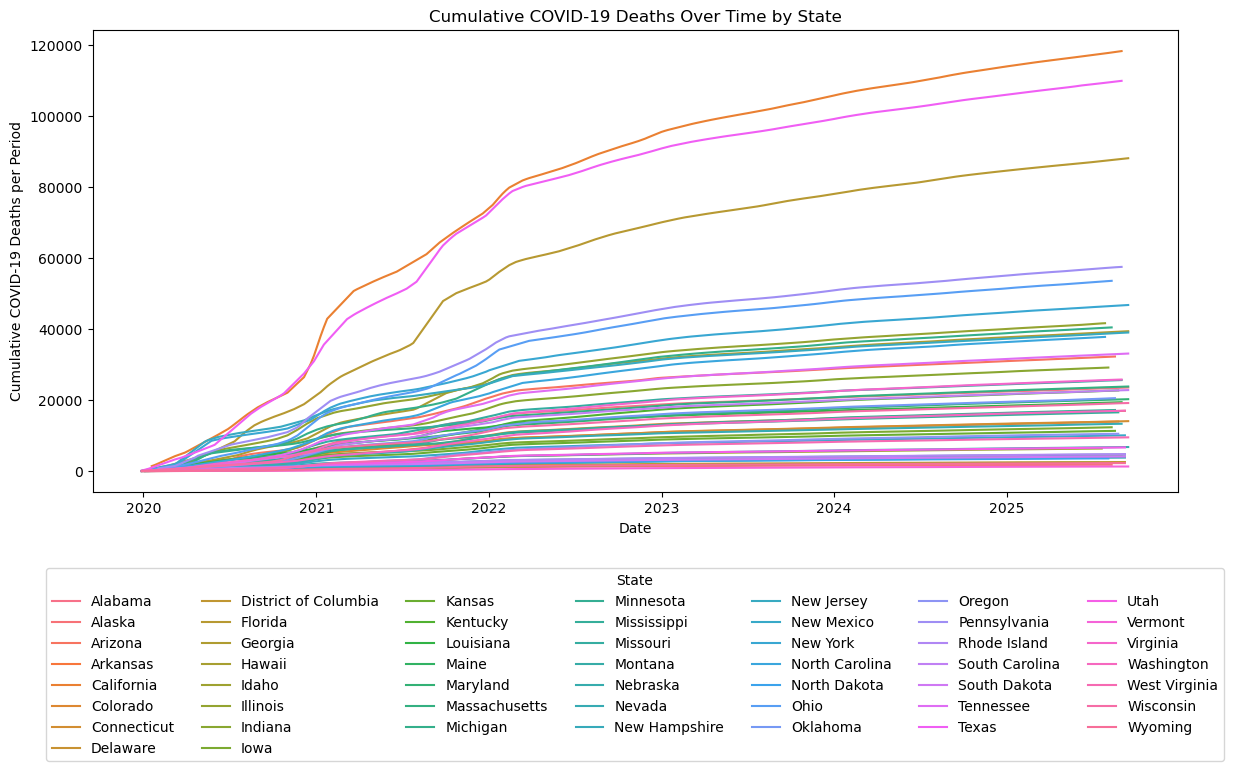

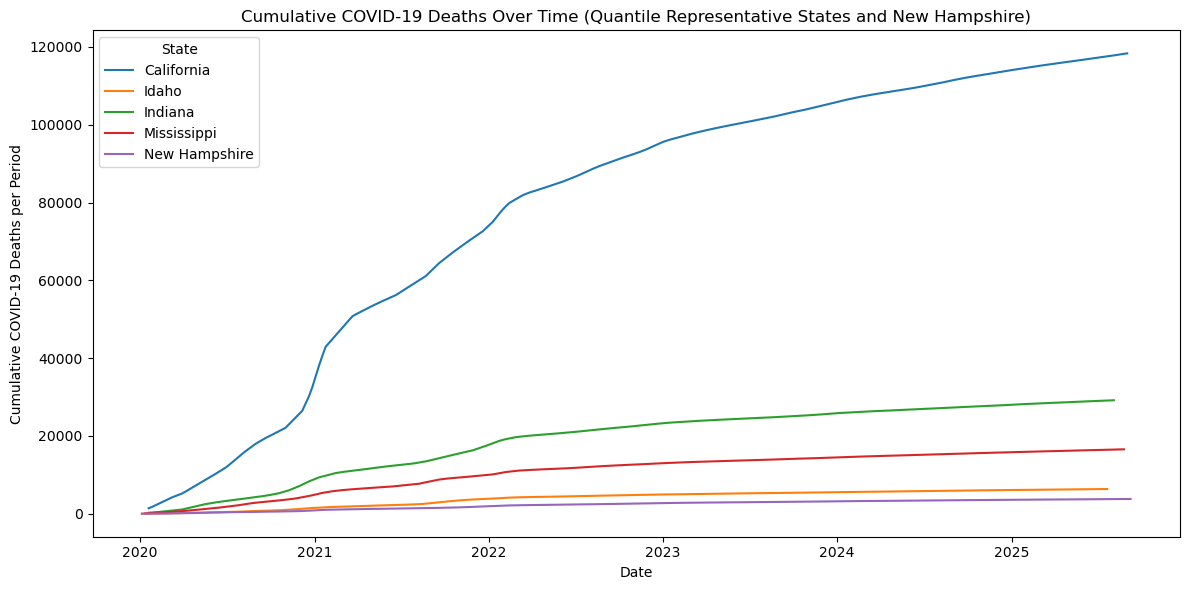

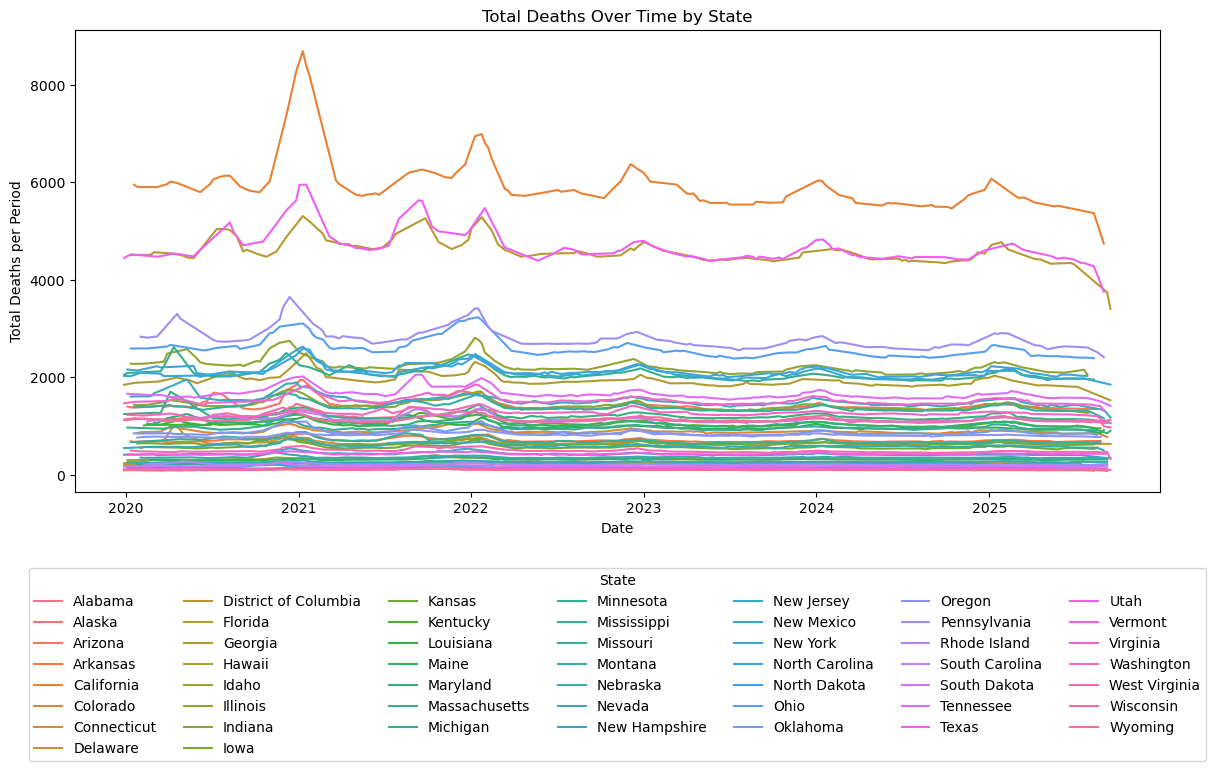

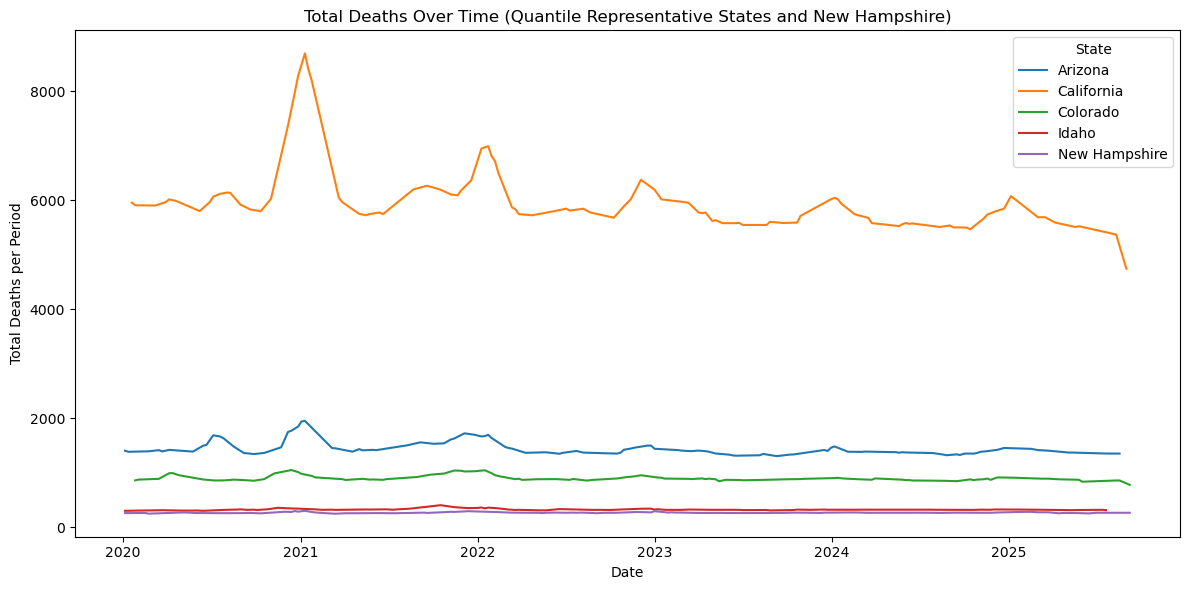

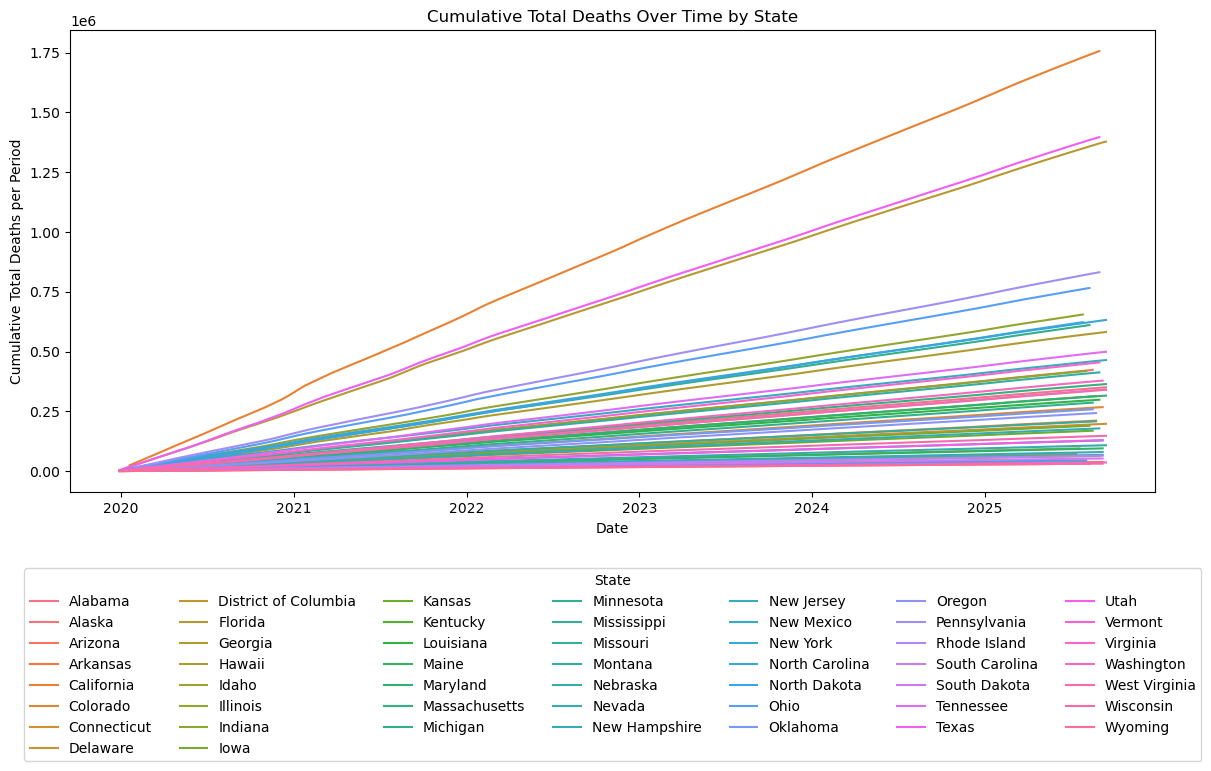

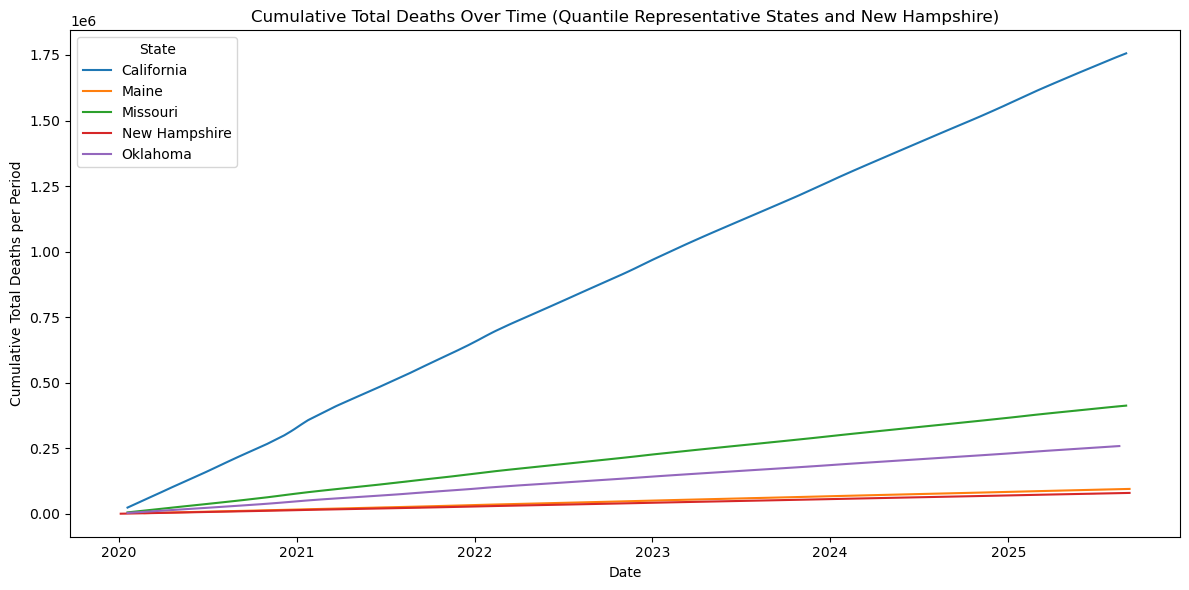

In [277]:
showScatterplot("COVID-19 Deaths")
showScatterplot("Cumulative COVID-19 Deaths")
showScatterplot("Total Deaths")
showScatterplot("Cumulative Total Deaths")

<h4><b>Heatmap of Mean COVID-19 Deaths by State and Mental Health Indicator</b></h4>

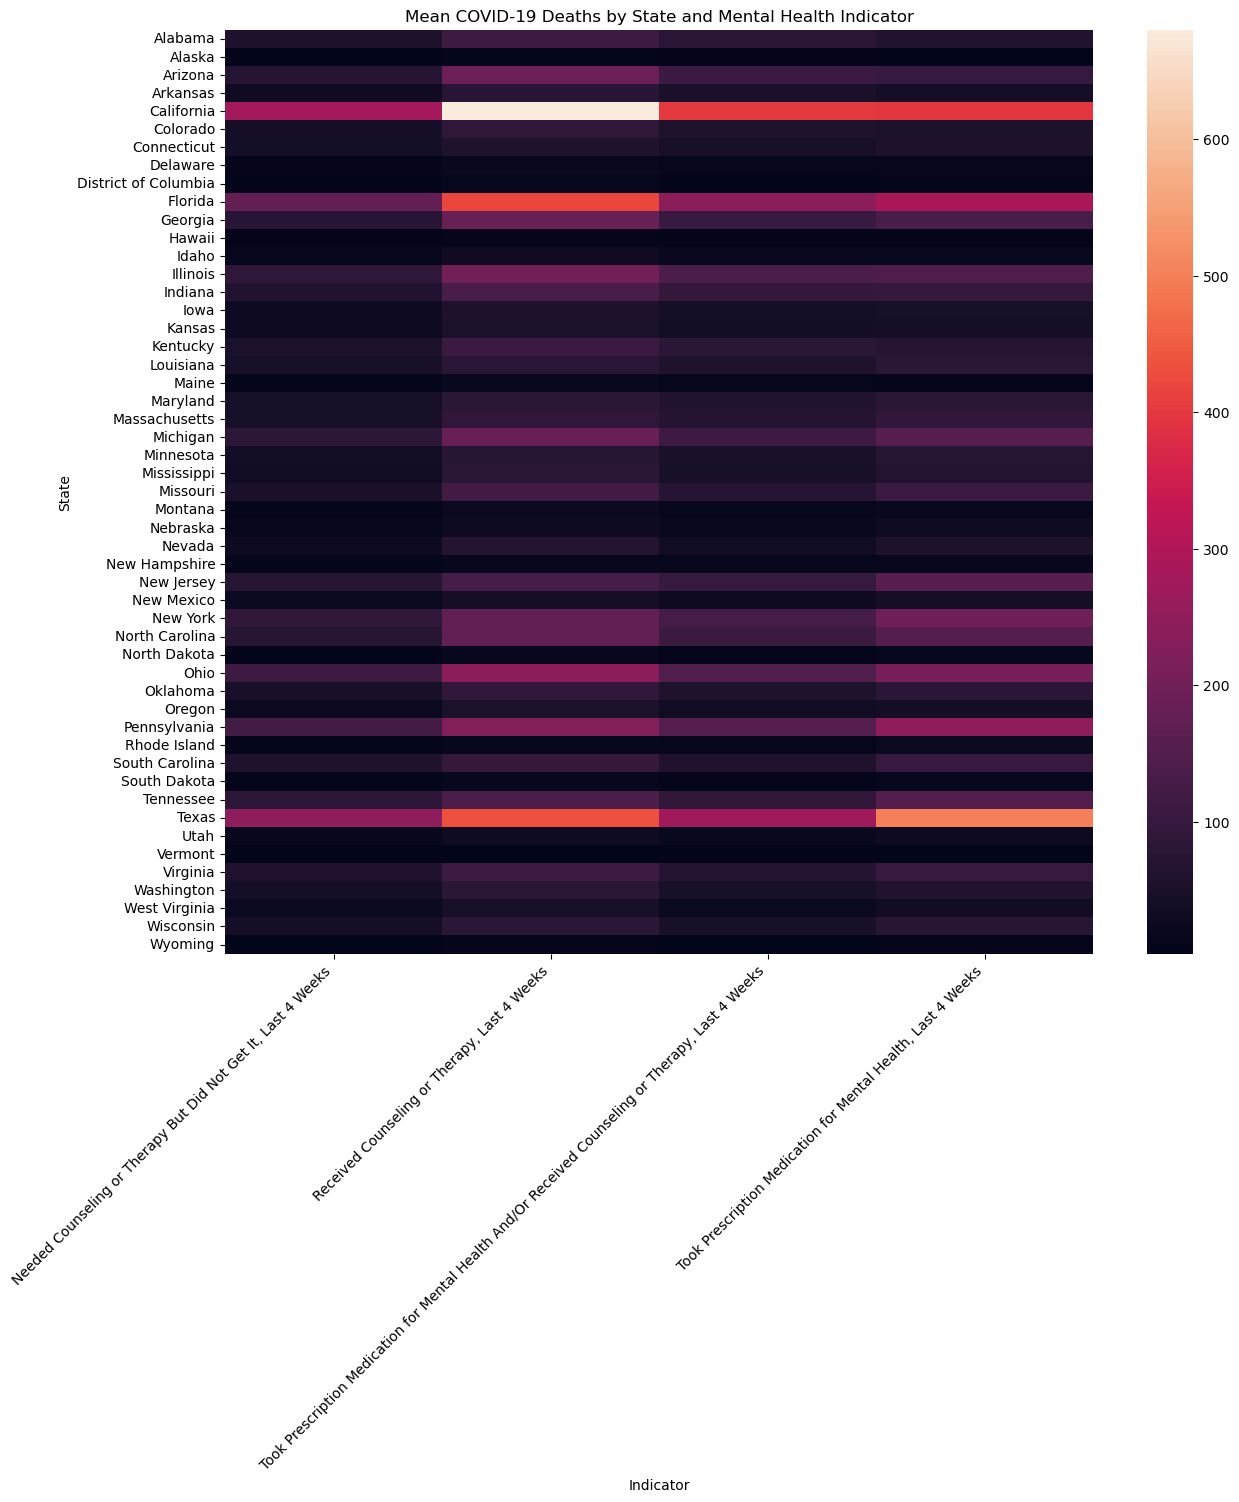

In [ ]:
# Create pivot table to show mean COVID-19 Deaths by state and indicator
pivot_table = finalData[finalData["State"] != "United States"].pivot_table(
    values = "COVID-19 Deaths",
    index = "State",
    columns = "Indicator",
    aggfunc = "mean"
)
# Create heatmap to display data
plt.figure(figsize = (14, 12))
sns.heatmap(pivot_table)
plt.title("Mean COVID-19 Deaths by State and Mental Health Indicator")
plt.xticks(rotation = 45, ha = "right")
plt.show()


<h3><b>Q4. Model Development and Application</b></h3>

In [ ]:
def runClassifierModel(inputData, numericFeatures, categoricalFeatures, target, modelName):
    x = inputData[numericFeatures + categoricalFeatures]
    y = inputData[target].values.ravel()
    # Split into train and test
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
    # Write preprocessor
    preprocessor = ColumnTransformer(
        transformers = [
            ("num", StandardScaler(), numericFeatures),
            ("cat", OneHotEncoder(handle_unknown = "ignore"), categoricalFeatures)
        ]
    )
    # Create pipeline based on modelName
    if modelName == "Logistic Regression":
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(solver = "lbfgs", max_iter = 1000))
        ])
    elif modelName == "Random Forest Classifier":
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(
                n_estimators = 300,
                max_depth = None,
                min_samples_split = 2,
                min_samples_leaf = 1,
                random_state = 42,
                n_jobs = -1
            ))
        ])
    elif modelName == "KNN Classifier":
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", KNeighborsClassifier(n_neighbors = 5, n_jobs = -1))
        ])
    elif modelName == "SVM":
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(kernel = "poly", probability = False, random_state = 42))
        ])
    else:
        print("No appropritate model selected")
        return
    # Train model
    pipe.fit(xTrain, yTrain)
    # Make predictions
    yPred = pipe.predict(xTest)
    # Return to compare results
    return yTest, yPred

def kMeansClusteringModel(inputData, numericFeatures, categoricalFeatures, maxClusters):
    x = inputData[numericFeatures + categoricalFeatures]
    # Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numericFeatures),
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categoricalFeatures)
    ])
    # Transform data once
    xTransform = preprocessor.fit_transform(x)
    # Defining lists to store values for elbow and sillhouette plots and krange
    inertiaValues = []
    silhouetteValues = []
    kRange = range(2, maxClusters + 1)
    # Finding intertia values and sillhouette scores for each k value in krange
    for k in kRange:
        kmeans = KMeans(n_clusters = k, random_state = 42)
        labels = kmeans.fit_predict(xTransform)
        inertiaValues.append(kmeans.inertia_)
        silhouetteValues.append(silhouette_score(xTransform, labels))
    # Pick the k with the highest silhouette score
    optimalK = kRange[silhouetteValues.index(max(silhouetteValues))]
    # Performing Kmeans using optimalK
    kMeansOutput = KMeans(n_clusters = optimalK, random_state = 42)
    clusterLabels = kMeansOutput.fit_predict(xTransform)
    # Add cluster labels to original dataframe (copy performed to remove warning)
    inputData = inputData.copy()
    inputData["Cluster"] = clusterLabels
    # Use 2 components for PCA to keep it 2D
    pca = PCA(n_components = 2)
    xPCA = pca.fit_transform(xTransform)
    # Plot the intertia values (elbow method)
    plt.figure(figsize = (14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(kRange, inertiaValues)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")
    # Plot silhouette scores
    plt.subplot(2, 2, 2)
    plt.plot(kRange, silhouetteValues)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for K values")
    # Plot clusters
    plt.subplot(2, 2, 3)
    cmap = plt.colormaps["tab10"].resampled(optimalK)
    plt.scatter(xPCA[:, 0], xPCA[:, 1], c = inputData["Cluster"], cmap = cmap, alpha = 0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Means Clusters (k =" + str(optimalK) + ")")
    cbar = plt.colorbar(ticks = range(optimalK))
    cbar.set_label("Cluster")
    # Plot points by indicator
    plt.subplot(2, 2, 4)
    sns.scatterplot(x = xPCA[:, 0], y = xPCA[:, 1], hue = inputData["Indicator"], alpha = 0.7)
    plt.title("PCA plot colored by Indicator")
    # Legend is on the outside of the plot to prevent blocking it
    plt.legend(title = "Indicator", loc = "upper center", bbox_to_anchor = (0.5, -0.15))
    plt.tight_layout()
    plt.show()
    # Print optimal k value chosen
    print("---- Optimal number of clusters based on silhouette score:", optimalK)
    print("\n---- Averages by cluster for each numeric feature:\n")
    print(inputData.groupby("Cluster")[numericFeatures].mean())
    print("\n---- Counts for each unique State per cluster\n")
    for i in categoricalFeatures:
        print(inputData.groupby("Cluster")[i].value_counts())
    print("\n---- Counts for each unique Indicator per cluster\n")
    print(pd.crosstab(inputData["Cluster"], inputData["Indicator"]))
    print("\n---- Distribution of Indicators by cluster\n")
    cluster_indicator_distribution = inputData.groupby("Cluster")["Indicator"].value_counts(normalize = True)
    print(cluster_indicator_distribution)

def printInfo(yTest, yPred):
    print("Accuracy:", accuracy_score(yTest, yPred))
    print("\nClassification Report:\n", classification_report(yTest, yPred))
    print("\nConfusion Matrix:\n", confusion_matrix(yTest, yPred))


<h4><b>Model 1 - Logistic Regression</b></h4>

In [261]:
# Intializing variables
numericFeatures = ['COVID-19 Deaths', 'Total Deaths', 'Cumulative COVID-19 Deaths', 'Cumulative Total Deaths']
categoricalFeatures = ['State']
target = ['Indicator']
modelResults = []
# Run model with 'United States' as a 'State'
print("----Metrics using all data----\n")
yTest, yPred = runClassifierModel(finalData, numericFeatures, categoricalFeatures, target, "Logistic Regression")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])
print("\n----Metrics not including 'State' == 'United States'----\n")
yTest, yPred = runClassifierModel(finalData[finalData["State"] != "United States"], numericFeatures, categoricalFeatures, target, "Logistic Regression")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])

----Metrics using all data----

Accuracy: 0.28159538683325325

Classification Report:
                                                                                                     precision    recall  f1-score   support

                                     Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks       0.28      0.30      0.29       520
                                                      Received Counseling or Therapy, Last 4 Weeks       0.29      0.27      0.28       520
Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks       0.30      0.30      0.30       521
                                      Took Prescription Medication for Mental Health, Last 4 Weeks       0.26      0.26      0.26       520

                                                                                          accuracy                           0.28      2081
                                                                       

<h4><b>Model 2 - Random Forest Classifier</b></h4>

In [262]:
# Run model with 'United States' as a 'State'
print("----Metrics using all data----\n")
yTest, yPred = runClassifierModel(finalData, numericFeatures, categoricalFeatures, target, "Random Forest Classifier")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])
# Run model without 'United States' as a 'State'
print("\n----Metrics not including 'State' == 'United States'----\n")
yTest, yPred = runClassifierModel(finalData[finalData["State"] != "United States"], numericFeatures, categoricalFeatures, target, "Random Forest Classifier")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])

----Metrics using all data----

Accuracy: 0.43728976453628066

Classification Report:
                                                                                                     precision    recall  f1-score   support

                                     Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks       0.44      0.44      0.44       520
                                                      Received Counseling or Therapy, Last 4 Weeks       0.43      0.43      0.43       520
Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks       0.46      0.45      0.45       521
                                      Took Prescription Medication for Mental Health, Last 4 Weeks       0.43      0.43      0.43       520

                                                                                          accuracy                           0.44      2081
                                                                       

<h4><b>Model 3 - K-Nearest-Neighbor (KNN)</b></h4>

In [263]:
# Run model with 'United States' as a 'State'
print("----Metrics using all data----\n")
yTest, yPred = runClassifierModel(finalData, numericFeatures, categoricalFeatures, target, "KNN Classifier")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])
# Run model without 'United States' as a 'State'
print("\n----Metrics not including 'State' == 'United States'----\n")
yTest, yPred = runClassifierModel(finalData[finalData["State"] != "United States"], numericFeatures, categoricalFeatures, target, "KNN Classifier")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])

----Metrics using all data----

Accuracy: 0.4368092263334935

Classification Report:
                                                                                                     precision    recall  f1-score   support

                                     Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks       0.43      0.49      0.46       520
                                                      Received Counseling or Therapy, Last 4 Weeks       0.41      0.46      0.43       520
Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks       0.44      0.38      0.41       521
                                      Took Prescription Medication for Mental Health, Last 4 Weeks       0.48      0.42      0.44       520

                                                                                          accuracy                           0.44      2081
                                                                        

<h4><b>Model 4 - Support Vector Machine (SVM)</b></h4>

In [264]:
# Run model with 'United States' as a 'State'
print("----Metrics using all data----\n")
yTest, yPred = runClassifierModel(finalData, numericFeatures, categoricalFeatures, target, "SVM")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])
# Run model without 'United States' as a 'State'
print("\n----Metrics not including 'State' == 'United States'----\n")
yTest, yPred = runClassifierModel(finalData[finalData["State"] != "United States"], numericFeatures, categoricalFeatures, target, "SVM")
printInfo(yTest, yPred)
modelResults.append([yTest, yPred])

----Metrics using all data----

Accuracy: 0.3104276790004805

Classification Report:
                                                                                                     precision    recall  f1-score   support

                                     Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks       0.39      0.21      0.27       520
                                                      Received Counseling or Therapy, Last 4 Weeks       0.27      0.67      0.38       520
Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks       0.57      0.16      0.25       521
                                      Took Prescription Medication for Mental Health, Last 4 Weeks       0.30      0.20      0.24       520

                                                                                          accuracy                           0.31      2081
                                                                        

<h4><b>Model 5 - K Means Clustering with Principal Component Analysis (PCA)</b></h4>

----Metrics using all data----



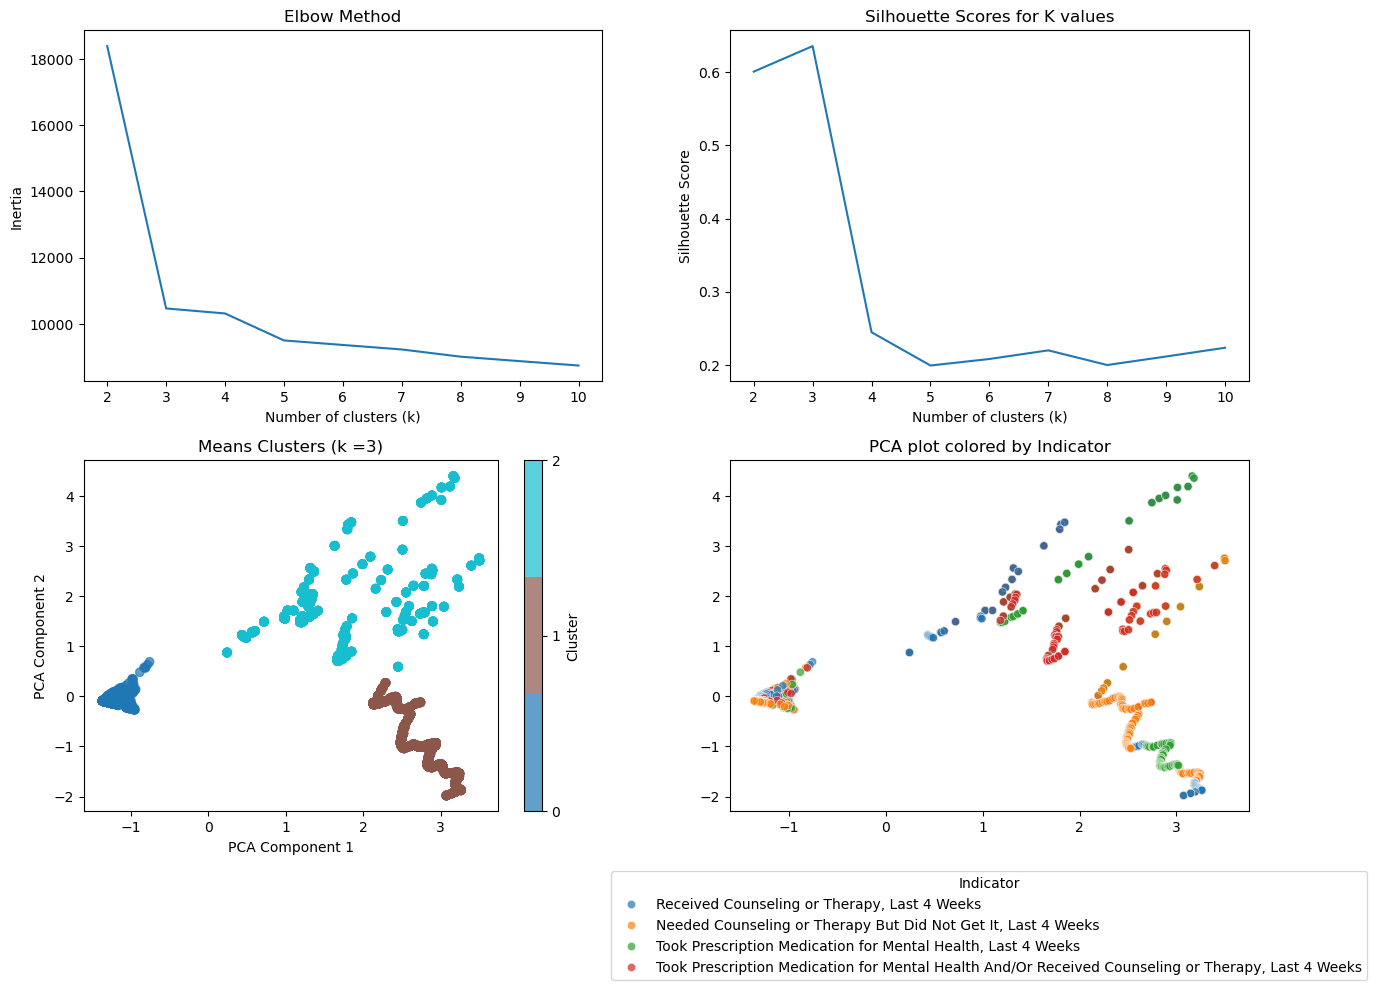

---- Optimal number of clusters based on silhouette score: 3

---- Averages by cluster for each numeric feature:

         COVID-19 Deaths  Total Deaths  Cumulative COVID-19 Deaths  \
Cluster                                                              
0              79.687813   1194.495502                1.571984e+04   
1            2212.433174  60017.413079                1.068219e+06   
2            7160.340143  65026.941027                3.612618e+05   

         Cumulative Total Deaths  
Cluster                           
0                   1.851472e+05  
1                   1.286901e+07  
2                   3.502721e+06  

---- Counts for each unique State per cluster

Cluster  State               
0        Alabama                  132
         Alaska                   132
         Arizona                  132
         Arkansas                 132
         California               132
         Colorado                 132
         Connecticut              132
         Delawar

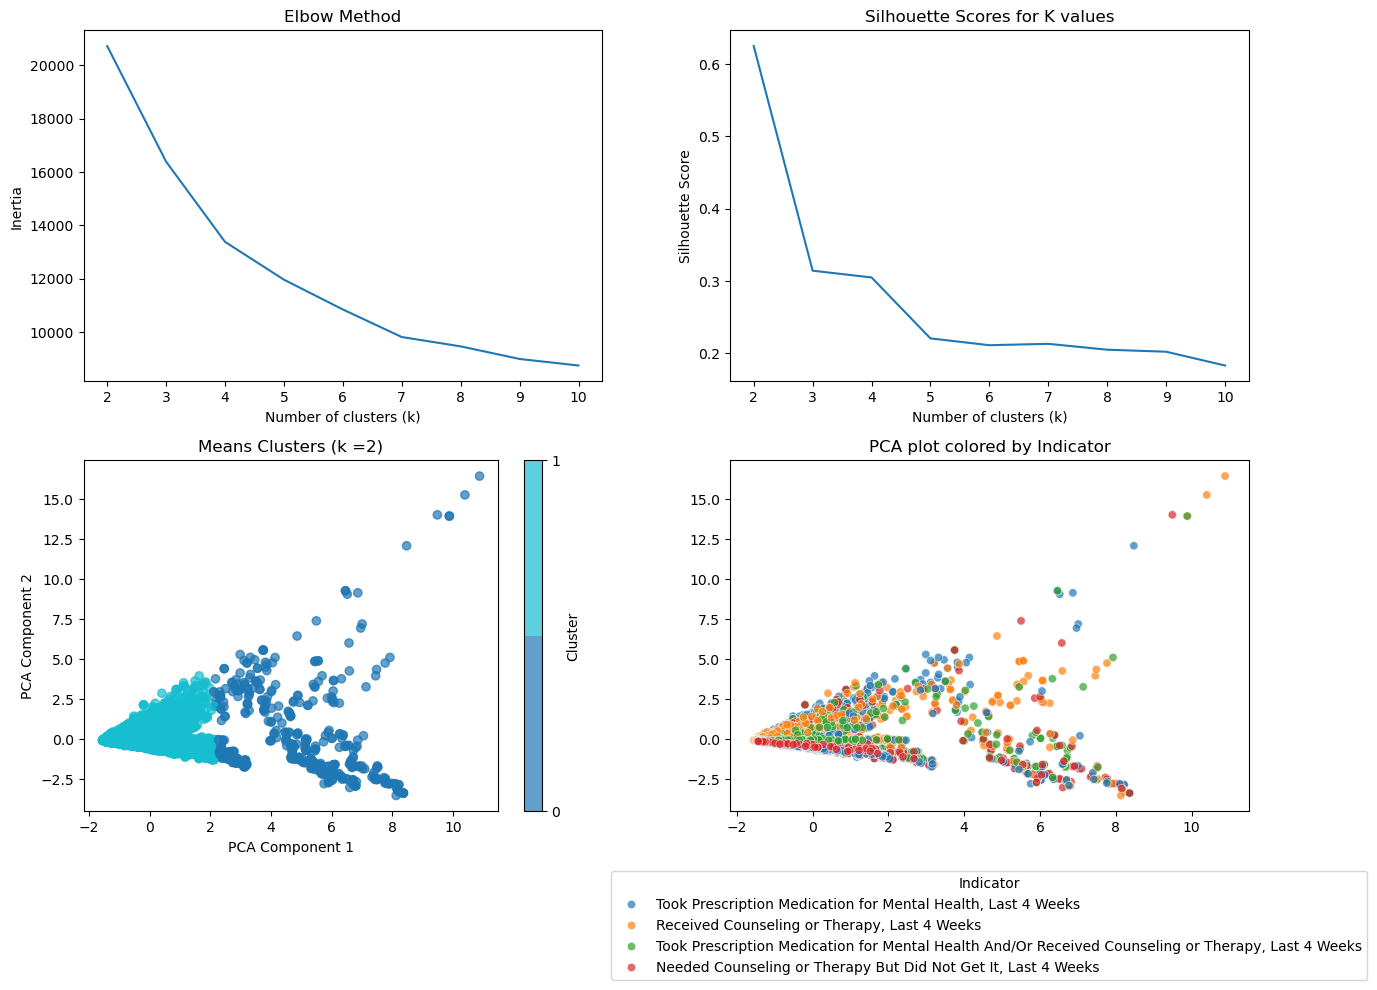

---- Optimal number of clusters based on silhouette score: 2

---- Averages by cluster for each numeric feature:

         COVID-19 Deaths  Total Deaths  Cumulative COVID-19 Deaths  \
Cluster                                                              
0             309.586622   4441.085873                66717.362342   
1              60.403112    922.160357                11441.987369   

         Cumulative Total Deaths  
Cluster                           
0                  754323.046065  
1                  137402.726830  

---- Counts for each unique State per cluster

Cluster  State               
0        California              132
         Florida                 124
         Texas                   121
         Pennsylvania             86
         Ohio                     55
         Illinois                  3
1        Alabama                 132
         Alaska                  132
         Arizona                 132
         Arkansas                132
         Colorado

In [265]:
# Run model with 'United States' as a 'State'
print("----Metrics using all data----\n")
kMeansClusteringModel(finalData, numericFeatures, categoricalFeatures, 10)
# Run model without 'United States' as a 'State'
print("\n----Metrics not including 'State' == 'United States'----\n")
kMeansClusteringModel(finalData[finalData["State"] != "United States"], numericFeatures, categoricalFeatures, 10)

<h4><b>Compare Results (Models 1-4)</b></h4>

In [276]:
modelNames = ["Logistic Regression", "Random Forest Classifier", "KNN Classifier", "SVM"]
modelResultsDF = {}
confusionMatricesDF = {}
for i in range(len(modelResults)):
    name = modelNames[math.floor(i/2)]
    if i % 2 != 0:
        name = name + " (without U.S. as a State)"
    modelResultsDF[name] = {
        "accuracy": round(accuracy_score(modelResults[i][0], modelResults[i][1]), 3),
        "precision": round(precision_score(modelResults[i][0], modelResults[i][1], average = "weighted"), 3),
        "recall": round(recall_score(modelResults[i][0], modelResults[i][1], average = "weighted"), 3),
        "f1score": round(f1_score(modelResults[i][0], modelResults[i][1], average = "weighted"), 3)
    }
    confusionMatricesDF[name] = confusion_matrix(modelResults[i][0], modelResults[i][1])
modelResultsDF = pd.DataFrame(modelResultsDF).T
print(modelResultsDF)
print("\n---- CONFUSION MATRICES")
for modelName, cm in confusionMatricesDF.items():
    print("\n-- " + modelName)
    print(pd.DataFrame(cm))


#KNN model performed best in all metrics

                                                    accuracy  precision  \
Logistic Regression                                    0.282      0.282   
Logistic Regression (without U.S. as a State)          0.398      0.397   
Random Forest Classifier                               0.437      0.437   
Random Forest Classifier (without U.S. as a State)     0.432      0.432   
KNN Classifier                                         0.437      0.439   
KNN Classifier (without U.S. as a State)               0.466      0.468   
SVM                                                    0.310      0.383   
SVM (without U.S. as a State)                          0.336      0.369   

                                                    recall  f1score  
Logistic Regression                                  0.282    0.281  
Logistic Regression (without U.S. as a State)        0.398    0.394  
Random Forest Classifier                             0.437    0.437  
Random Forest Classifier (without U.S. as a 